In [6]:
# Utilities
import matplotlib.pyplot as plt
import pandas as pd
import getpass

from sentinelhub import (
    SHConfig,
    DataCollection,
    SentinelHubCatalog,
    SentinelHubRequest,
    SentinelHubStatistical,
    BBox,
    bbox_to_dimensions,
    CRS,
    MimeType,
    Geometry,
)

from utils import plot_image

In [7]:
config = SHConfig()
config.sh_client_id = getpass.getpass("sh-94636a97-fbd8-4965-b285-9a851e980d02")
config.sh_client_secret = getpass.getpass("gQbtizScacfmfQSNvKGNEX5TTyl9VC39")
config.sh_token_url = "https://identity.dataspace.copernicus.eu/auth/realms/CDSE/protocol/openid-connect/token"
config.sh_base_url = "https://sh.dataspace.copernicus.eu"

sh-94636a97-fbd8-4965-b285-9a851e980d02 ········
gQbtizScacfmfQSNvKGNEX5TTyl9VC39 ········


In [15]:
# define functions to extract statistics for all acquisition dates
def extract_stats(date, stat_data):
    d = {}
    for key, value in stat_data["outputs"].items():
        stats = value["bands"]["B0"]["stats"]
        if stats["sampleCount"] == stats["noDataCount"]:
            continue
        else:
            d["date"] = [date]
            for stat_name, stat_value in stats.items():
                if stat_name == "sampleCount" or stat_name == "noDataCount":
                    continue
                else:
                    d[f"{key}_{stat_name}"] = [stat_value]
    return pd.DataFrame(d)


def read_acquisitions_stats(stat_data):
    df_li = []
    for aq in stat_data:
        date = aq["interval"]["from"][:10]
        df_li.append(extract_stats(date, aq))
    return pd.concat(df_li)

In [16]:
aoi_coords_wgs84 = [15.56, 46.84, 15.574922, 46.851514]

In [17]:
catalog = SentinelHubCatalog(config=config)

In [18]:
evalscript_ndvi = """
//VERSION=3
function setup() {
  return {
    input: [{
      bands: [
        "B04",
        "B08",
        "dataMask"
      ]
    }],
    output: [
      {
        id: "ndvi",
        bands: 1
      },
      {
        id: "dataMask",
        bands: 1
      }]
  };
}

function evaluatePixel(samples) {
    let index = (samples.B08 - samples.B04) / (samples.B08+samples.B04);
    return {
        ndvi: [index],
        dataMask: [samples.dataMask],
    };
}

"""

In [19]:
evalscript_ndwi = """
//VERSION=3
function setup() {
  return {
    input: [{
      bands: [
        "B03", // Green band
        "B08", // NIR band
        "dataMask" // Mask to exclude the non-valid pixels
      ]
    }],
    output: [
      {
        id: "ndwi",
        bands: 1,
        sampleType: "FLOAT32"
      },
      {
        id: "dataMask",
        bands: 1
      }
    ]
  };
}

function evaluatePixel(samples) {
    let ndwi = (samples.B03 - samples.B08) / (samples.B03 + samples.B08);
    return {
        ndwi: [ndwi],
        dataMask: [samples.dataMask],
    };
}
"""




In [20]:
field1 = {
    "type": "Polygon",
    "coordinates": [
        [
            [15.541723001099184, 46.820368115848446],
            [15.541756949727985, 46.82037740810231],
            [15.54192669287196, 46.82008470133467],
            [15.542211861353849, 46.81964331510048],
            [15.539394125163792, 46.81905789197882],
            [15.539251540922846, 46.819805931503055],
            [15.541723001099184, 46.820368115848446],
        ]
    ],
}

In [22]:
geometry = Geometry(geometry=field1, crs=CRS.WGS84)

request_ndvi = SentinelHubStatistical(
    aggregation=SentinelHubStatistical.aggregation(
        evalscript=evalscript_ndvi,
        time_interval=("2022-04-01T00:00:00Z", "2022-08-30T23:59:59Z"),
        aggregation_interval="P1D",
        size=[368.043, 834.345],
    ),
    input_data=[
        SentinelHubStatistical.input_data(
            DataCollection.SENTINEL2_L1C.define_from(
                name="s2l1c", service_url="https://sh.dataspace.copernicus.eu"
            ),
            other_args={"dataFilter": {"maxCloudCoverage": 10}},
        ),
    ],
    geometry=geometry,
    config=config,
)

request_ndwi = SentinelHubStatistical(
    aggregation=SentinelHubStatistical.aggregation(
        evalscript=evalscript_ndwi,
        time_interval=("2022-04-01T00:00:00Z", "2022-08-30T23:59:59Z"),
        aggregation_interval="P1D",
        size=[368.043, 834.345],
    ),
    input_data=[
        SentinelHubStatistical.input_data(
            DataCollection.SENTINEL2_L1C.define_from(
                name="s2l1c", service_url="https://sh.dataspace.copernicus.eu"
            ),
            other_args={"dataFilter": {"maxCloudCoverage": 10}},
        ),
    ],
    geometry=geometry,
    config=config,
)


response_ndvi = request_ndvi.get_data()
response_ndwi = request_ndwi.get_data()

In [23]:
result_ndvi = read_acquisitions_stats(response_ndvi[0]["data"])
result_ndvi

,date,ndvi_min,ndvi_max,ndvi_mean,ndvi_stDev
0,2022-04-25,0.081676,0.396040,0.133466,0.067784
0,2022-05-12,0.074978,0.411669,0.117876,0.056860
0,2022-05-15,0.092130,0.466552,0.137653,0.062204
0,2022-05-20,0.076008,0.434946,0.117718,0.060065
0,2022-05-22,0.120710,0.222202,0.162361,0.021199
0,2022-06-01,0.128842,0.494173,0.177038,0.049541
0,2022-06-04,0.192227,0.479948,0.245432,0.043656
0,2022-06-06,0.306978,0.558544,0.387164,0.036878
0,2022-06-19,0.493226,0.762313,0.716632,0.036329
0,2022-06-26,0.523532,0.847210,0.813441,0.043345


In [24]:
result_ndwi = read_acquisitions_stats(response_ndwi[0]["data"])
result_ndwi

,date,ndwi_min,ndwi_max,ndwi_mean,ndwi_stDev
0,2022-04-25,-0.383307,-0.173742,-0.210320,0.045268
0,2022-05-12,-0.382268,-0.159232,-0.197421,0.038196
0,2022-05-15,-0.413784,-0.144349,-0.187474,0.044629
0,2022-05-20,-0.410677,-0.164450,-0.200892,0.041457
0,2022-05-22,-0.213056,-0.154146,-0.180554,0.011934
0,2022-06-01,-0.438186,-0.218353,-0.247024,0.029008
0,2022-06-04,-0.421450,-0.254321,-0.291369,0.026272
0,2022-06-06,-0.449951,-0.275679,-0.341065,0.024399
0,2022-06-19,-0.641530,-0.450999,-0.612822,0.023146
0,2022-06-26,-0.695972,-0.444342,-0.672985,0.028501


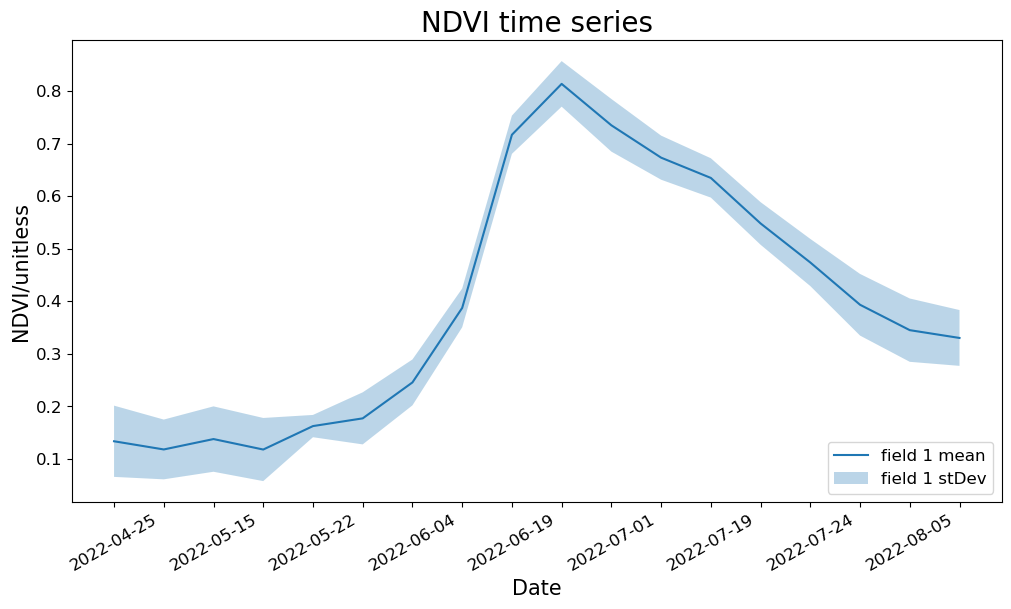

In [25]:
fig_stat, ax_stat = plt.subplots(1, 1, figsize=(12, 6))
t1 = result_ndvi["date"]
ndvi_mean_field1 = result_ndvi["ndvi_mean"]
ndvi_std_field1 = result_ndvi["ndvi_stDev"]
ax_stat.plot(t1, ndvi_mean_field1, label="field 1 mean")
ax_stat.fill_between(
    t1,
    ndvi_mean_field1 - ndvi_std_field1,
    ndvi_mean_field1 + ndvi_std_field1,
    alpha=0.3,
    label="field 1 stDev",
)
ax_stat.tick_params(axis="x", labelrotation=30, labelsize=12)
ax_stat.tick_params(axis="y", labelsize=12)
ax_stat.set_xlabel("Date", size=15)
ax_stat.set_ylabel("NDVI/unitless", size=15)
ax_stat.legend(loc="lower right", prop={"size": 12})
ax_stat.set_title("NDVI time series", fontsize=20)
for label in ax_stat.get_xticklabels()[1::2]:
    label.set_visible(False)

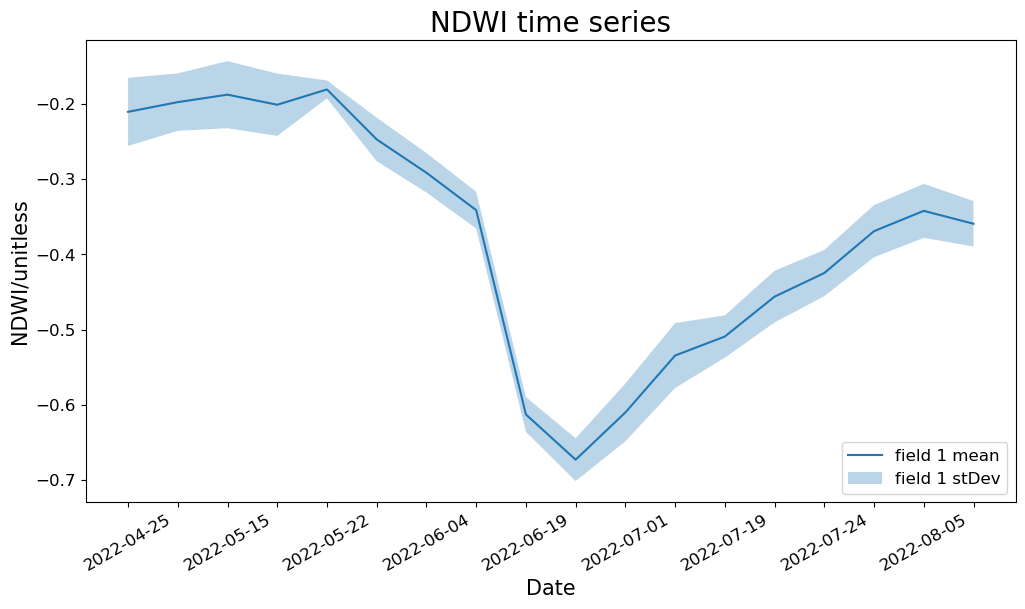

In [26]:
fig_stat, ax_stat = plt.subplots(1, 1, figsize=(12, 6))
t1 = result_ndwi["date"]
ndwi_mean_field1 = result_ndwi["ndwi_mean"]
ndwi_std_field1 = result_ndwi["ndwi_stDev"]
ax_stat.plot(t1, ndwi_mean_field1, label="field 1 mean")
ax_stat.fill_between(
    t1,
    ndwi_mean_field1 - ndwi_std_field1,
    ndwi_mean_field1 + ndwi_std_field1,
    alpha=0.3,
    label="field 1 stDev",
)
ax_stat.tick_params(axis="x", labelrotation=30, labelsize=12)
ax_stat.tick_params(axis="y", labelsize=12)
ax_stat.set_xlabel("Date", size=15)
ax_stat.set_ylabel("NDWI/unitless", size=15)
ax_stat.legend(loc="lower right", prop={"size": 12})
ax_stat.set_title("NDWI time series", fontsize=20)
for label in ax_stat.get_xticklabels()[1::2]:
    label.set_visible(False)